




# Vision Transformer (ViT) Finetuning
In this notebook you will finetune a pretrained Vision Transformer to predict a class
We won't train a model by ourself but rather use the power of freely available models which are pretrained by others on a large set of images (Imagenet
 14'197'122 images 1000 Classes). 

 There is  a library which provides us with the necessary models
 py**T**orch **IM**age **M**odels (timm):
 
https://github.com/huggingface/pytorch-image-models
https://huggingface.co/docs/hub/timm
 
 This notebook consist of the following steps:


1.   Download & set the weights to a given modelarchitecture
2.   Finetuen model on CIFAR10

Imagenet: https://www.image-net.org/about.php

VisionTransformer: https://arxiv.org/abs/2010.11929


-------

In [ ]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Configuration
model_name = "vit_base_patch16_224"
batch_size = 128
epochs = 10
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)




# Data Preparation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize CIFAR-10 images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Pretrained Model
model = create_model(model_name, pretrained=True, num_classes=10)  # CIFAR-10 has 10 classes
model = model.to(device)
print("Model Loaded with Configuration:", model.default_cfg)


# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

def train(model, loader, optimizer, criterion, device,n_batches=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
        

        # Print a message after each batch
        print(f"Batch {batch_idx + 1}/{len(loader)} completed.")
        if n_batches == batch_idx:
            break
    
    acc = 100. * correct / total
    print(f"Train Loss: {running_loss/len(loader):.4f}, Accuracy: {acc:.2f}%")
    return running_loss / len(loader), acc

# Testing Function
def test(model, loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    outputs_list = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            outputs_list.append(outputs)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            
            
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    
    acc = 100. * correct / total
    print(f"Test Loss: {test_loss/len(loader):.4f}, Accuracy: {acc:.2f}%")
    return test_loss / len(loader), acc , outputs_list

Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Model Loaded with Configuration: {'url': '', 'hf_hub_id': 'timm/vit_base_patch16_224.augreg2_in21k_ft_in1k', 'architecture': 'vit_base_patch16_224', 'tag': 'augreg2_in21k_ft_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'fixed_input_size': True, 'interpolation': 'bicubic', 'crop_pct': 0.9, 'crop_mode': 'center', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'num_classes': 1000, 'pool_size': None, 'first_conv': 'patch_embed.proj', 'classifier': 'head'}


lets check the label distribution on the test set

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

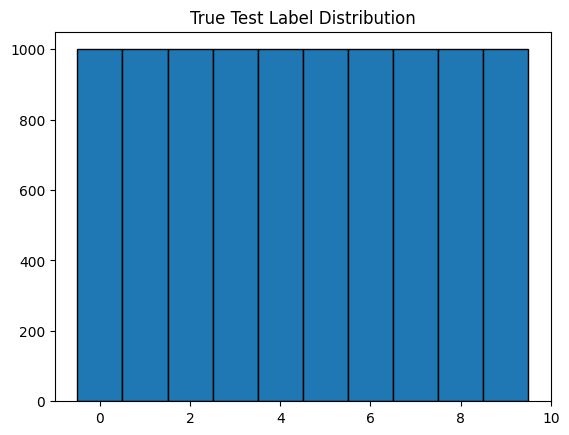

In [2]:
y_true=list(test_dataset.targets)
plt.title("True Test Label Distribution")
plt.hist(y_true,np.arange(0,11), edgecolor='black', align='left')

Ok lets now check what the model outputs when its not finetuned on the task
- what do you expect? 
- note that the model has no notion of the cifar class assignemt.
- also since the classification head is newly specified to 10 classes the weights are randomly initalized (for the mlp head)

In [ ]:
print("\nEvaluating the model before training:")

_, _ ,out= test(model, test_loader, criterion, device)
output=[l.detach().cpu().numpy() for l in out]
output=np.concatenate(output)
plt.hist(list(np.argmax(output,axis=1)), edgecolor='black', align='left')


- the accuracy / loss can  not be interpreted here since the classes can not be assigned.

lets see what happens if we train with only with a few batches..

In [ ]:
n_batches=10

# Configuration
model_name = "vit_base_patch16_224"
batch_size = 64
epochs = 1
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


# Load Pretrained Model
model = create_model(model_name, pretrained=True, num_classes=10)  # surprise surprise CIFAR-10 has 10 classes
model = model.to(device)
print("Model Loaded with Configuration:", model.default_cfg)


# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)


# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device,n_batches=n_batches-1)
    test_loss, test_acc,_ = test(model, test_loader, criterion, device)

print(f"Fine-tuning with {n_batches} batches completed!")

Device: cuda
Model Loaded with Configuration: {'url': '', 'hf_hub_id': 'timm/vit_base_patch16_224.augreg2_in21k_ft_in1k', 'architecture': 'vit_base_patch16_224', 'tag': 'augreg2_in21k_ft_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'fixed_input_size': True, 'interpolation': 'bicubic', 'crop_pct': 0.9, 'crop_mode': 'center', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'num_classes': 1000, 'pool_size': None, 'first_conv': 'patch_embed.proj', 'classifier': 'head'}
Epoch 1/1
Batch 1/391 completed.
Batch 2/391 completed.
Batch 3/391 completed.
Batch 4/391 completed.
Batch 5/391 completed.
Batch 6/391 completed.
Batch 7/391 completed.
Batch 8/391 completed.
Batch 9/391 completed.
Batch 10/391 completed.
Batch 11/391 completed.
Batch 12/391 completed.
Batch 13/391 completed.
Batch 14/391 completed.
Batch 15/391 completed.
Batch 16/391 completed.
Batch 17/391 completed.
Batch 18/391 completed.
Batch 19/391 completed.
Batch 20/391 completed.
Batch 21/391 completed.
Batch 22/39


- just seeing 10* 640 images (with random rotations)  once was enough to 

If you want you can finetune the model furteher
- adjust epochs
- track loss


In [ ]:
# Configuration
model_name = "vit_base_patch16_224"
batch_size = 64
epochs = 20
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


# Load Pretrained Model
model = create_model(model_name, pretrained=True, num_classes=10)  # surprise surprise CIFAR-10 has 10 classes
model = model.to(device)
print("Model Loaded with Configuration:", model.default_cfg)


# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)


# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device,n_batches=None)
    test_loss, test_acc,_ = test(model, test_loader, criterion, device)

print("Fine-tuning completed!")